# Comparison of dgemm calibrations w.r.t. how the matrices are generated

In these experiments, we perform calls to dgemm with three square matrices of order 2,048.

We will look at dgemm performance and the node temperatures and frequencies for different matrix generation methods. Each element of the matrix is set to some random number between 0 and 1. Then, we apply a mask to set its N lowest order bits to 1.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    df['index'] = range(len(df))
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

914230ba92388decf817f2c9606f3021d5d159be


In [2]:
directories = ['matrix_generation/dahu/' + str(i) for i in [1, 2]]

def get_monitoring(archive_name, csv_name, min_start=None, max_stop=None):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    if min_start is not None:
        old_len = len(df)
        df = df[df['start'] >= pandas.to_timedelta(min_start, unit='s')]
#        print('Archive %s: removed %d entries that happened before time %.2f s' % (archive_name, old_len-len(df), min_start))
    if max_stop is not None:
        old_len = len(df)
        df = df[df['stop'] <= pandas.to_timedelta(max_stop, unit='s')]
#        print('Archive %s: removed %d entries that happened after time %.2f s' % (archive_name, old_len-len(df), max_stop))
    if min_start is not None:
        first = df['start'].min()
        df['start'] -= first
        df['stop'] -= first
    return df

def read_archive(archive_name):
    df = read_csv(archive_name, 'result.csv')
    df['start'] = df['timestamp']
    df['end'] = df['start'] + df['duration']
    df['mnk'] = df['m'] * df['n'] * df['k']
    df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
    core_mapping = ae.platform_to_cpu_mapping(ae.get_platform(archive_name))
    df['cpu'] = df.apply(lambda row: core_mapping[row.core], axis=1)
    info = get_yaml(archive_name, 'info.yaml')
    installfile = info['installfile']
    matrix_init = get_yaml(archive_name, installfile)['matrix_initialization']
    try:
        mask_size = get_yaml(archive_name, installfile)['matrix_initialization_mask_size']
    except KeyError:
        mask_size = 0
    hosts = [key for key in info.keys() if key.endswith('grid5000.fr')]
    assert len(hosts) == 1
    host = hosts[0]
    start_time = df['start'].min()
    stop_time = df['end'].max()
    df['start'] -= start_time
    df['end'] -= start_time
    temperature = get_monitoring(archive_name, 'monitoring_temp.csv', start_time, stop_time)
    temperature['cpu'] = temperature['sensor_id']
    frequencies = get_monitoring(archive_name, 'monitoring_freq.csv', start_time, stop_time)
    frequencies['frequency'] *= 1e-9
    frequencies = frequencies[frequencies['core_id'] < len(df.core.unique())]  # removing the hyperthread cores
    frequencies['cpu'] = frequencies.apply(lambda row: core_mapping[row.core_id], axis=1)
    for tmp in [df, temperature, frequencies]:
        tmp['matrix_content'] = matrix_init
        tmp['mask_size'] = mask_size
        tmp['host'] = host
    return df, temperature, frequencies

dataframes = []
cluster = set()
for directory in directories:
    for filename in os.listdir(directory):
        if not filename.endswith('.zip'):
            continue
        path = os.path.join(directory, filename)
        cluster.add(get_yaml(path, 'info.yaml')['cluster'])
        dataframes.append(read_archive(path))
assert len(cluster) == 1
cluster = cluster.pop()

performance = pandas.concat([t[0] for t in dataframes])
temperature = pandas.concat([t[1] for t in dataframes])
frequency   = pandas.concat([t[2] for t in dataframes])

performance = performance[performance['matrix_content'] == 'random']
temperature = temperature[temperature['matrix_content'] == 'random']
frequency = frequency[frequency['matrix_content'] == 'random']

performance.head()

,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,jobid,index,start,end,mnk,gflops,cpu,matrix_content,mask_size,host
0,dgemm,2048,2048,2048,2048,2048,2048,318.242900,0.621353,0,1889762,0,1.978242,2.599595,8589934592,27.649120,0,random,0,dahu-29.grenoble.grid5000.fr
1,dgemm,2048,2048,2048,2048,2048,2048,318.864276,0.635894,0,1889762,1,2.599618,3.235512,8589934592,27.016893,0,random,0,dahu-29.grenoble.grid5000.fr
2,dgemm,2048,2048,2048,2048,2048,2048,319.500178,0.641870,0,1889762,2,3.235520,3.877390,8589934592,26.765328,0,random,0,dahu-29.grenoble.grid5000.fr
3,dgemm,2048,2048,2048,2048,2048,2048,320.142057,0.635214,0,1889762,3,3.877399,4.512613,8589934592,27.045797,0,random,0,dahu-29.grenoble.grid5000.fr
4,dgemm,2048,2048,2048,2048,2048,2048,320.777279,0.634759,0,1889762,4,4.512621,5.147380,8589934592,27.065184,0,random,0,dahu-29.grenoble.grid5000.fr


In [3]:
temperature.head()

,hostname,start,stop,sensor_id,temperature,jobid,index,cpu,matrix_content,mask_size,host
632,dahu-29.grenoble.grid5000.fr,00:00:00,00:00:00.000258,0,74.0,1889762,632,0,random,0,dahu-29.grenoble.grid5000.fr
633,dahu-29.grenoble.grid5000.fr,00:00:00,00:00:00.000258,1,64.0,1889762,633,1,random,0,dahu-29.grenoble.grid5000.fr
634,dahu-29.grenoble.grid5000.fr,00:00:01.003721,00:00:01.003973,0,75.0,1889762,634,0,random,0,dahu-29.grenoble.grid5000.fr
635,dahu-29.grenoble.grid5000.fr,00:00:01.003721,00:00:01.003973,1,63.0,1889762,635,1,random,0,dahu-29.grenoble.grid5000.fr
636,dahu-29.grenoble.grid5000.fr,00:00:02.007430,00:00:02.007686,0,73.0,1889762,636,0,random,0,dahu-29.grenoble.grid5000.fr


In [4]:
frequency.head()

,hostname,start,stop,core_id,frequency,jobid,index,cpu,matrix_content,mask_size,host
20224,dahu-29.grenoble.grid5000.fr,0 days,00:00:00.002129,0,2.130889,1889762,20224,0,random,0,dahu-29.grenoble.grid5000.fr
20225,dahu-29.grenoble.grid5000.fr,0 days,00:00:00.002129,1,2.120123,1889762,20225,1,random,0,dahu-29.grenoble.grid5000.fr
20226,dahu-29.grenoble.grid5000.fr,0 days,00:00:00.002129,2,2.134094,1889762,20226,0,random,0,dahu-29.grenoble.grid5000.fr
20227,dahu-29.grenoble.grid5000.fr,0 days,00:00:00.002129,3,2.114739,1889762,20227,1,random,0,dahu-29.grenoble.grid5000.fr
20228,dahu-29.grenoble.grid5000.fr,0 days,00:00:00.002129,4,2.134094,1889762,20228,0,random,0,dahu-29.grenoble.grid5000.fr


## Performance

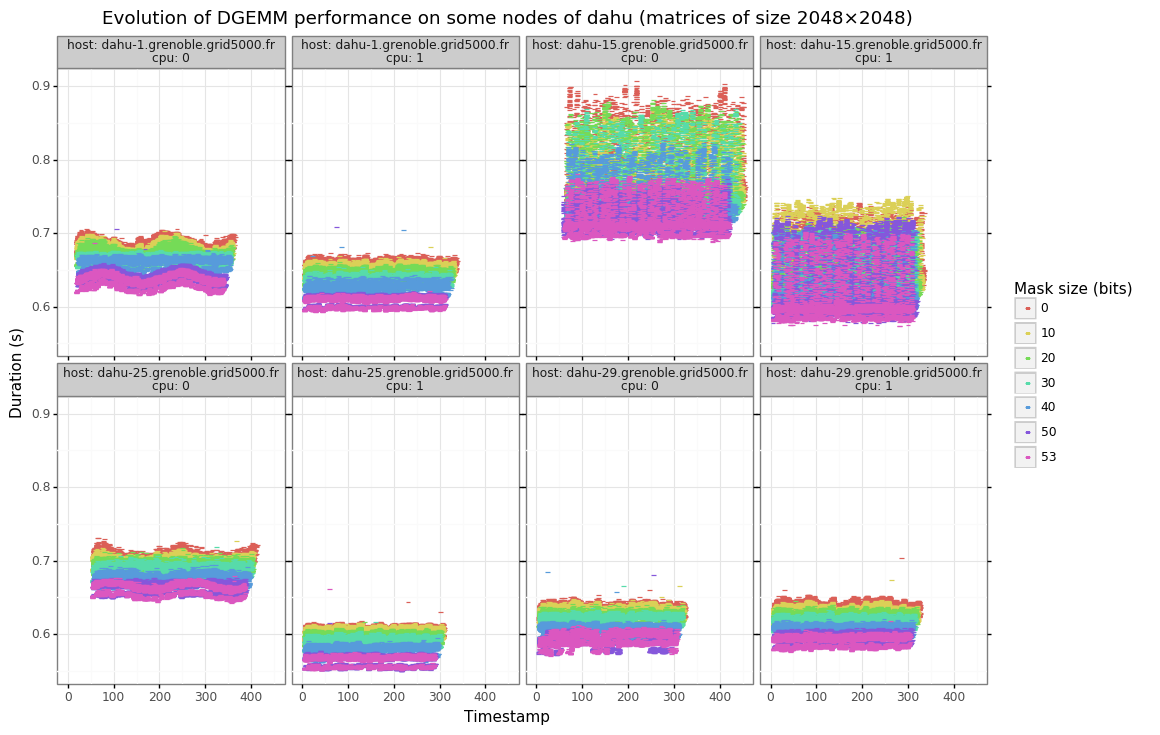

<ggplot: (-9223363294028089803)>

In [5]:
plot = ggplot(performance, aes(x='start', y='duration', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Duration (s)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Evolution of DGEMM performance on some nodes of %s (matrices of size 2048×2048)' % cluster)
plot

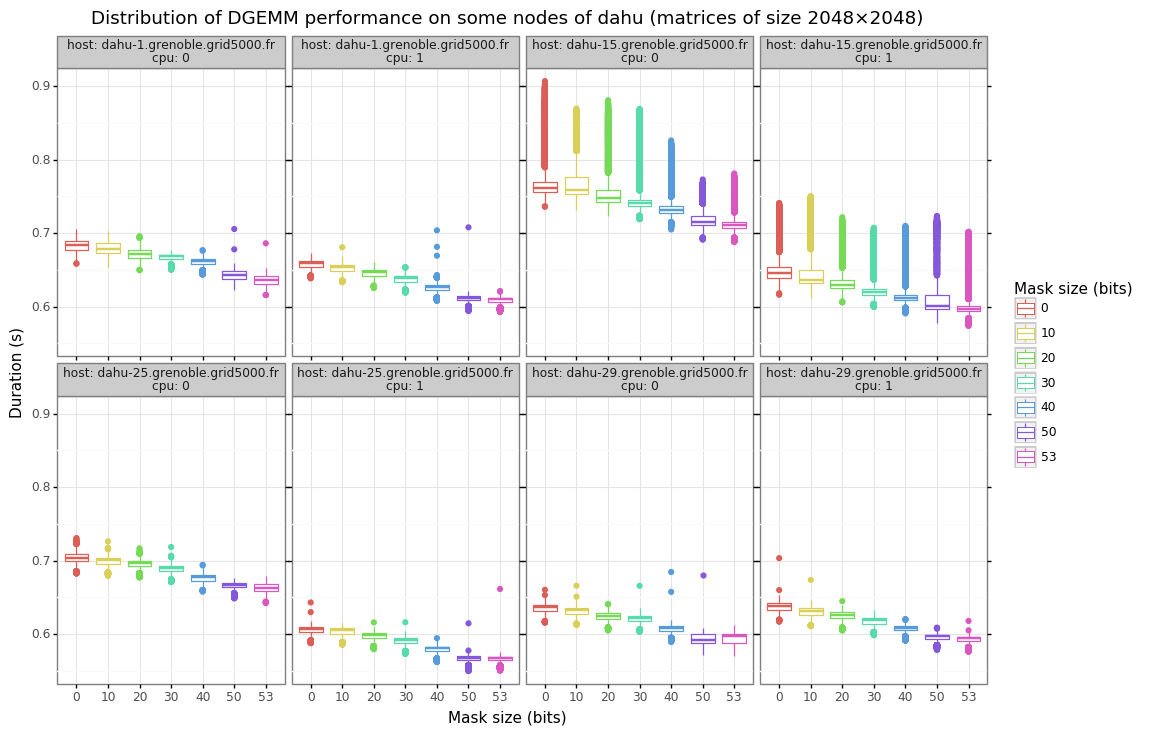

<ggplot: (8742779535820)>

In [6]:
plot = ggplot(performance, aes(x='factor(mask_size)', y='duration', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Mask size (bits)') + ylab('Duration (s)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Distribution of DGEMM performance on some nodes of %s (matrices of size 2048×2048)' % cluster)
plot

In [7]:
aggr = performance.groupby(['host', 'cpu', 'mask_size'])[['duration']].mean()
aggr

duration
host                         cpu mask_size          
dahu-1.grenoble.grid5000.fr  0   0          0.683388
                                 10         0.678811
                                 20         0.671193
                                 30         0.666492
                                 40         0.660223
                                 50         0.642796
                                 53         0.636010
                             1   0          0.657599
                                 10         0.652412
                                 20         0.645175
                                 30         0.636868
                                 40         0.625272
                                 50         0.609880
                                 53         0.607939
dahu-15.grenoble.grid5000.fr 0   0          0.774613
                                 10         0.770096
                                 20         0.761358
                                 30         0.748659
                                 40         0.738003
                                 50         0.719181
                                 53         0.715766
                             1   0          0.653680
                                 10         0.650201
                                 20         0.637851
                                 30         0.624857
                                 40         0.621368
                                 50         0.616759
                                 53         0.606203
dahu-25.grenoble.grid5000.fr 0   0          0.703510
                                 10         0.698967
                                 20         0.695038
                                 30         0.688616
                                 40         0.676225
                                 50         0.664939
                                 53         0.662648
                             1   0          0.605457
                                 10         0.603496
                                 20         0.596878
                                 30         0.590871
                                 40         0.578862
                                 50         0.565947
                                 53         0.565436
dahu-29.grenoble.grid5000.fr 0   0          0.634957
                                 10         0.631370
                                 20         0.623787
                                 30         0.620949
                                 40         0.606971
                                 50         0.593492
                                 53         0.594482
                             1   0          0.637291
                                 10         0.631024
                                 20         0.624947
                                 30         0.617471
                                 40         0.606699
                                 50         0.595527
                                 53         0.592362

## Temperature

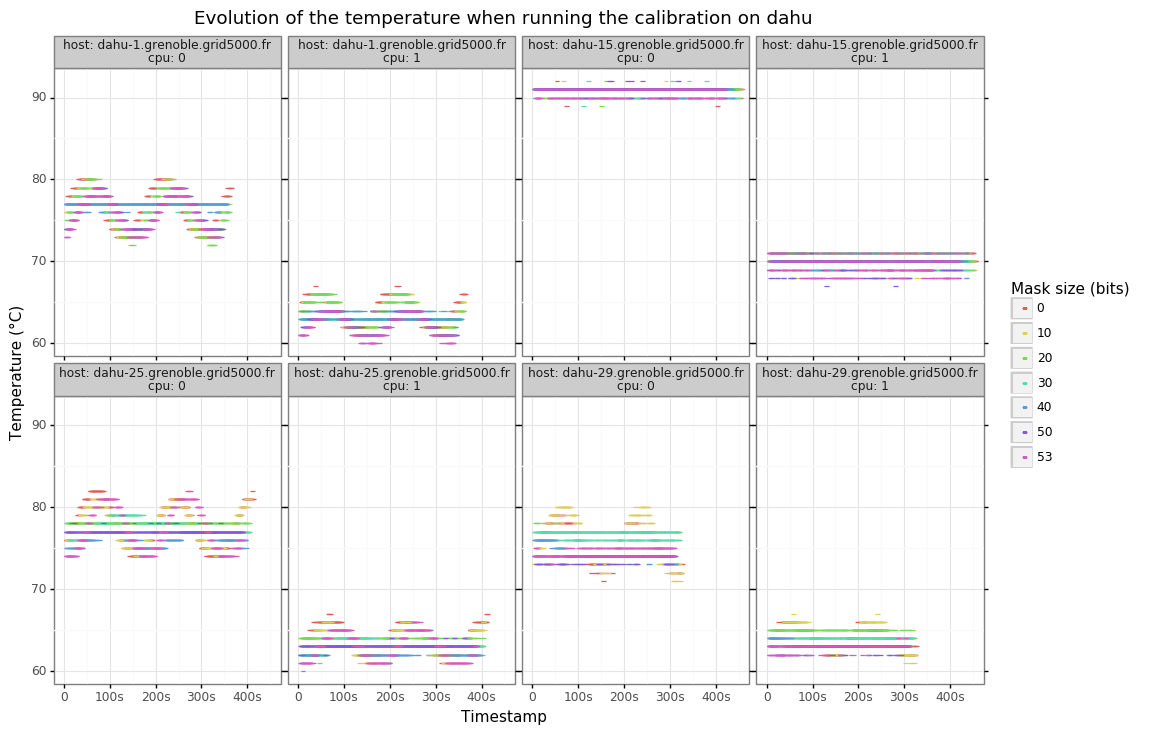

<ggplot: (-9223363294028314599)>

In [8]:
plot = ggplot(temperature, aes(x='start', y='temperature', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Evolution of the temperature when running the calibration on %s' % cluster)
plot

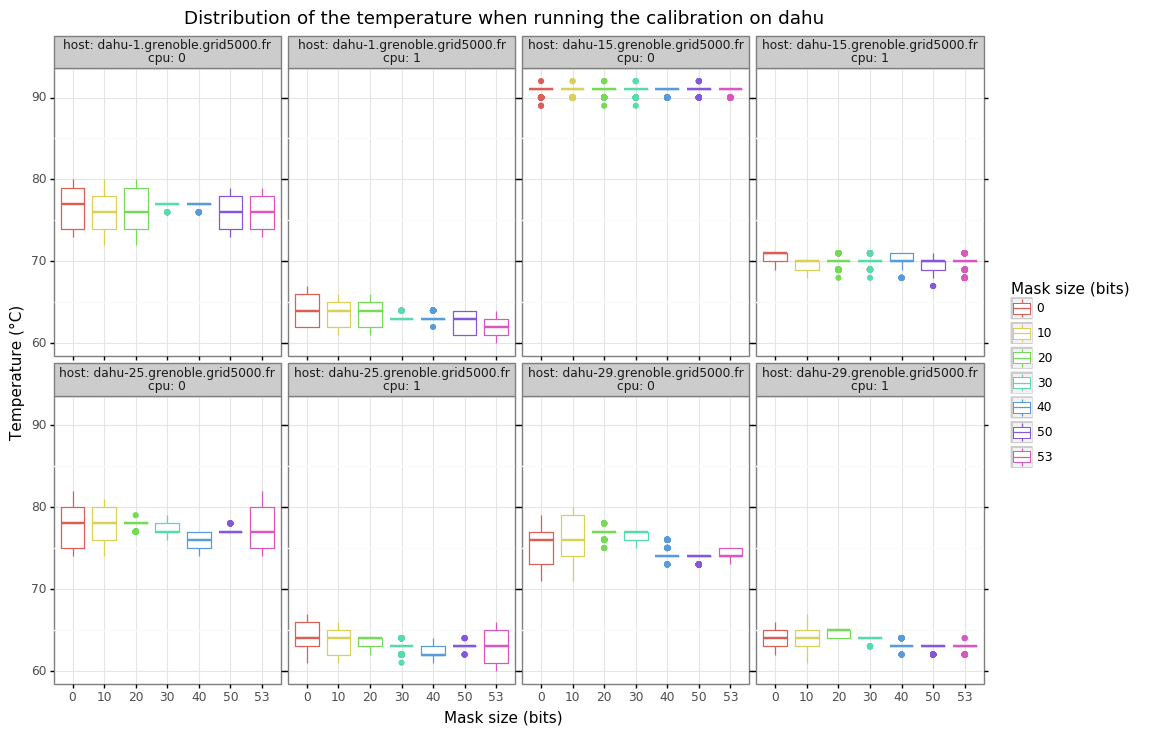

<ggplot: (-9223363293978099631)>

In [9]:
plot = ggplot(temperature, aes(x='factor(mask_size)', y='temperature', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Mask size (bits)') + ylab('Temperature (°C)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Distribution of the temperature when running the calibration on %s' % cluster)
plot

## Frequency

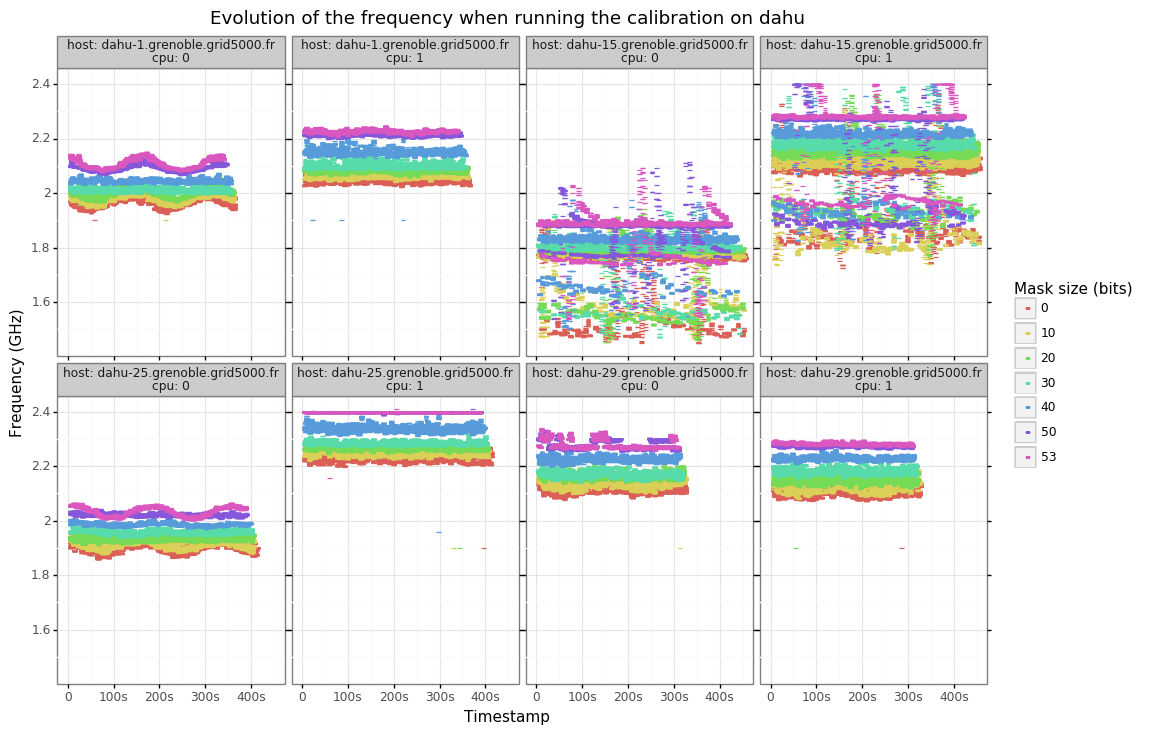

<ggplot: (8742781933141)>

In [10]:
plot = ggplot(frequency, aes(x='start', y='frequency', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_point(shape=1) + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Evolution of the frequency when running the calibration on %s' % cluster)
plot

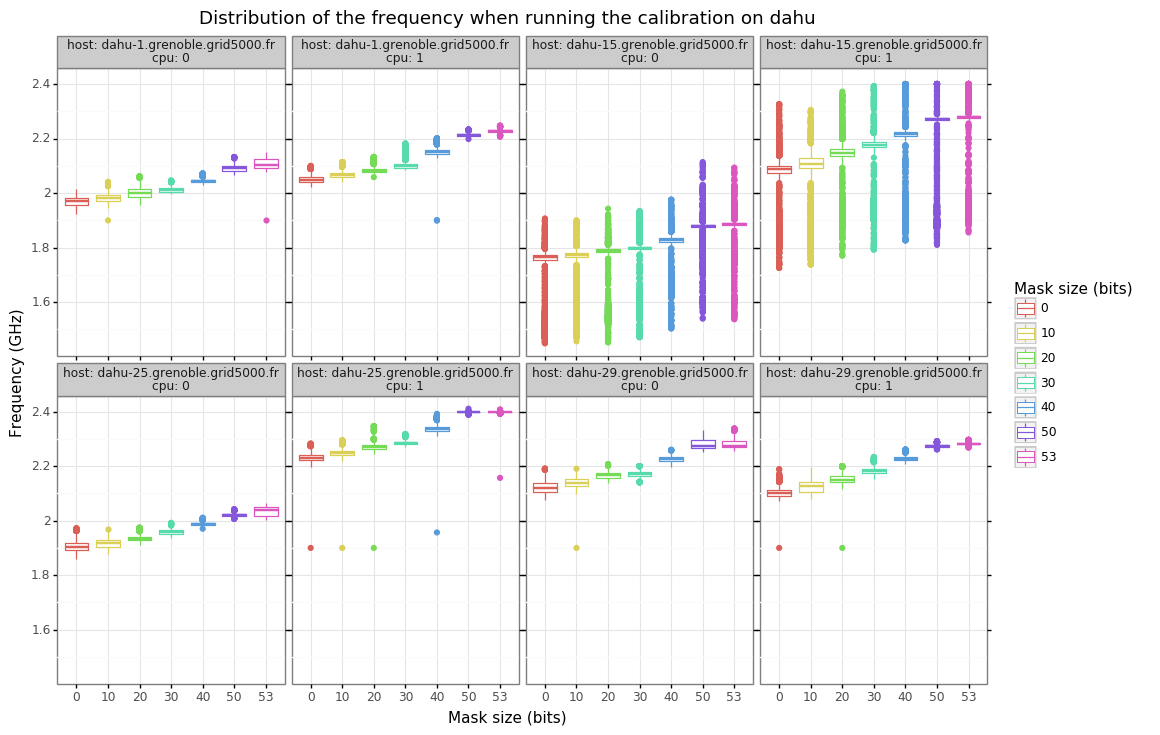

<ggplot: (-9223363294073462335)>

In [11]:
plot = ggplot(frequency, aes(x='factor(mask_size)', y='frequency', color='factor(mask_size)')) + theme_bw()
plot = plot + geom_boxplot() + facet_wrap(['host', 'cpu'], labeller='label_both', ncol=4)
plot = plot + xlab('Mask size (bits)') + ylab('Frequency (GHz)') + labs(color='Mask size (bits)')
plot = plot + ggtitle('Distribution of the frequency when running the calibration on %s' % cluster)
plot